In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product


In [2]:
class Dummy_obj:
    def __init__(self, onnx, vnnlib, n_splits, ot, st, bt, res_o, res_s, res_b):
        self.onnx, self.vnnlib, self.n_splits = onnx, vnnlib, int(n_splits)
        self.ot, self.st, self.bt = float(ot), float(st), float(bt)
        self.res_o, self.res_s, self.res_b = res_o, res_s, res_b
    def __str__(self):
        return f"Instance: {self.onnx}, {self.vnnlib}, {self.n_splits}, {self.res_o}, {self.res_b}, {self.res_s}, {self.ot}, {self.bt}, {self.st}"

In [3]:
def load_csv(file):
    with open(file) as f:
        f.readline()
        rows = []
        for l in f:
#             onnx,vnnlib,strategy,mask,n_splits,original_r,original_t,splitted_r,splitted_t,baseline_r,baseline_t
            fileds = l.split(',')
            assert len(fileds)==11
            if fileds[4] == "SKIPPED":
                rows.append( Dummy_obj(fileds[0], fileds[1], -1, -1, -1, -1, -1, -1, -1) )
                continue
            rows.append( Dummy_obj(fileds[0], fileds[1], fileds[4], 
                                   fileds[6], fileds[8], fileds[10], 
                                   fileds[5], fileds[7], fileds[9]) )
    return (file.stem, rows)
            

In [13]:
exp1_path = Path("/Users/linhan/relusplitter/experiment/results/exp1")
results = []
for f in exp1_path.iterdir():
    if f.suffix != ".csv":
        continue
    if "marabou" in f.stem:
        continue
    if "acas" not in f.stem:
        continue
    results.append(load_csv(f))
    print(f.stem)

acasxu~nnenum~stable~random~1
acasxu~abcrown~stable~random~1
acasxu~neuralsat~stable~random~1


In [57]:
# check for conflicting verification results
nns   = []
props = []
props2keep = ["prop_1","prop_2","prop_3","prop_4"]

conflicting = []

for d1,d2,d3 in zip(*[i[1] for i in results]):
    assert d1.onnx == d2.onnx == d3.onnx
    assert d1.vnnlib == d2.vnnlib == d3.vnnlib
    
    res = [d1.res_o, d2.res_o, d3.res_o]
    verified_res = [i for i in res if i in ["sat", "unsat"]]
    if len(set(verified_res)) > 1:
        print(d1.onnx, d1.vnnlib)
        print(res)
        conflicting.append((d1.onnx, d1.vnnlib))
        continue
    if d1.vnnlib not in props2keep:
        continue
    if d1.onnx not in nns:
        nns.append(d1.onnx)
    if d1.vnnlib not in props:
        props.append(d1.vnnlib)

# print('\n'.join(nns))
# print(props)
print(len(nns), len(props))


ACASXU_run2a_2_4_batch_2000_converted prop_3
['sat', 'unsat', 'unsat']
ACASXU_run2a_2_9_batch_2000_converted prop_3
['sat', 'unsat', 'unsat']
ACASXU_run2a_5_7_batch_2000_converted prop_3
['sat', 'unsat', 'unsat']
ACASXU_run2a_5_9_batch_2000_converted prop_3
['sat', 'unsat', 'unsat']
ACASXU_run2a_2_9_batch_2000_converted prop_4
['sat', 'unsat', 'unsat']
45 4


In [58]:
# drop skipped instances
filtered_res = []
for n,dps in results:
    dps_ = [dp for dp in dps if dp.res_o in ["sat", "unsat"]]
    dps_ = [dp for dp in dps_ if (dp.onnx, dp.vnnlib) not in conflicting]
    dps_ = [dp for dp in dps_ if dp.vnnlib in props2keep]
    filtered_res.append((n, dps_))
    print(len(dps)-len(dps_))

11
11
13


In [101]:
import matplotlib.lines as mlines
instance_offset = 0.1
fontsize=16

acasxu~nnenum~stable~random~1
acasxu~abcrown~stable~random~1
acasxu~neuralsat~stable~random~1


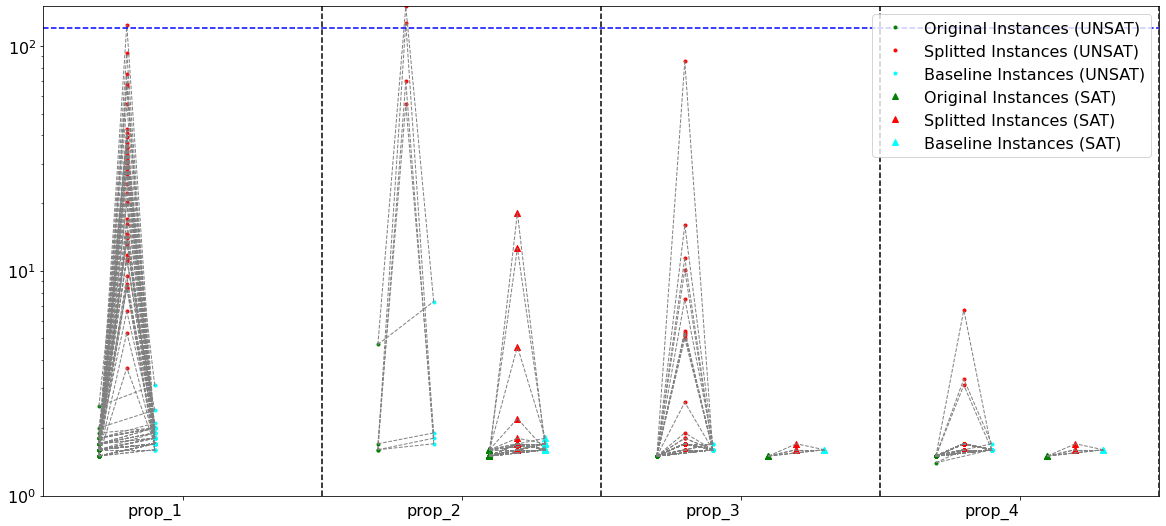

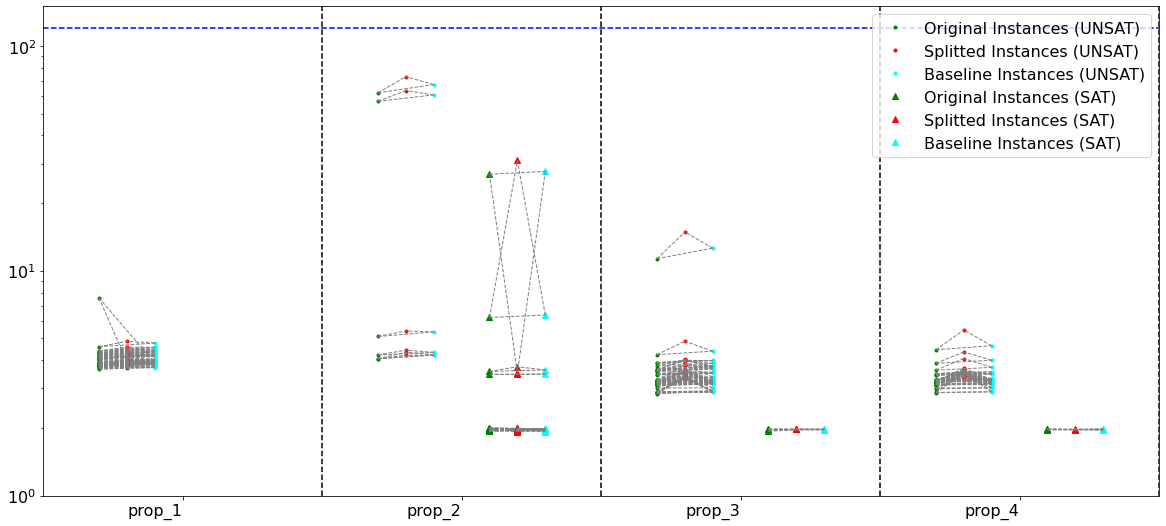

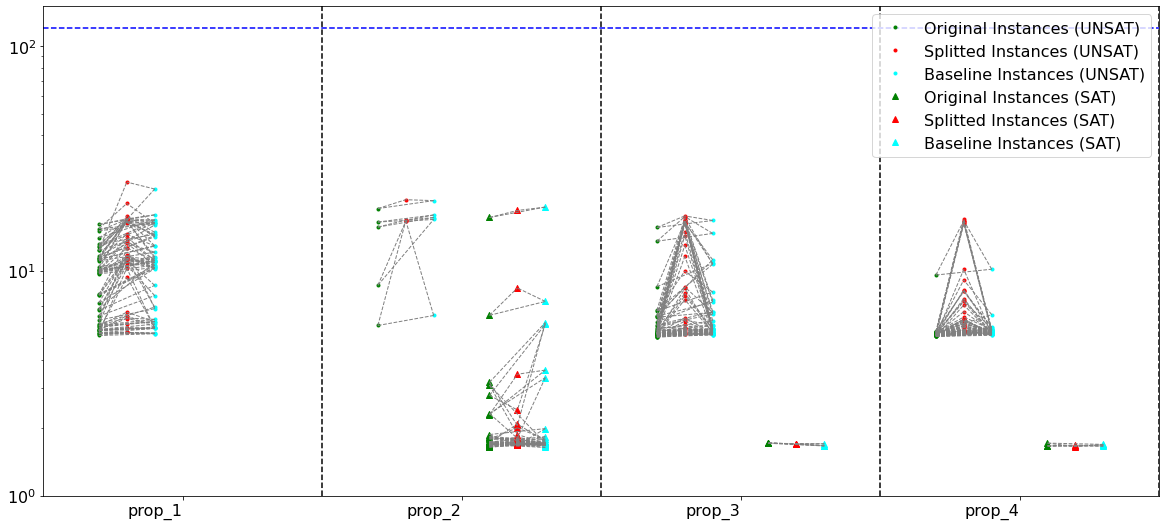

In [104]:
vnnlib_map = {vnnlib:val+0.2 for vnnlib, val in zip(props, list(range(len(props))))}
res_offset = {
                "unsat":0,
                "sat"  :0.4 
}


line_width = 1

timeout = 120

xmin, xmax = 0, len(vnnlib_map)
ymin, ymax = 1, timeout+30




for fname, dps in filtered_res:
    print(fname)
    plt.figure(figsize=(20,9))

    
    for dp in dps:
        # filter inconsistent verification result
        veri_ans = [dp.res_o, dp.res_b, dp.res_s]
        if "error" in veri_ans:
            continue
        veri_ans = list(set([i for i in veri_ans if i in ["sat", "unsat"]]))
        if len(veri_ans)>1:
            print(fname, dp)
            continue
            
        res = dp.res_o
        x = vnnlib_map[dp.vnnlib] + res_offset[res]
        xo,xs,xb = x+0*instance_offset, x+1*instance_offset, x+2*instance_offset
        plt.scatter(xo, dp.ot, color="green", label="Original Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        plt.scatter(xs, dp.st, color="red", label="Splitted Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        plt.scatter(xb, dp.bt, color="cyan", label="Baseline Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        
        plt.plot((xo,xb),(dp.ot, dp.bt), linestyle='--', color='gray', linewidth=line_width)
        plt.plot((xo,xs),(dp.ot, dp.st), linestyle='--', color='gray', linewidth=line_width)
        plt.plot((xb,xs),(dp.bt, dp.st), linestyle='--', color='gray', linewidth=line_width)
        
    plt.yscale('log')
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.plot([xmin, xmax], [timeout, timeout], linestyle="--", color='blue')
    
    for x in [1, 2, 3, 4, 5, 6]:
        plt.plot([x, x], [ymin, ymax], linestyle="--", color='black')
    
    plt.yticks(fontsize=fontsize)
    plt.xticks([i+0.3 for i in vnnlib_map.values()], list(vnnlib_map.keys()), rotation=0, ha='right', fontsize=fontsize)
    
    unsat_o = mlines.Line2D([], [], color='green', marker='.', linestyle='None', label='Original Instances (UNSAT)')
    unsat_s = mlines.Line2D([], [], color='red', marker='.', linestyle='None', label='Splitted Instances (UNSAT)')
    unsat_b = mlines.Line2D([], [], color='cyan', marker='.', linestyle='None', label='Baseline Instances (UNSAT)')
    sat_o = mlines.Line2D([], [], color='green', marker='^', linestyle='None', label='Original Instances (SAT)')
    sat_s = mlines.Line2D([], [], color='red', marker='^', linestyle='None', label='Splitted Instances (SAT)')
    sat_b = mlines.Line2D([], [], color='cyan', marker='^', linestyle='None', label='Baseline Instances (SAT)')
    plt.legend(handles=[unsat_o, unsat_s, unsat_b, sat_o, sat_s, sat_b], loc='upper right', fontsize=fontsize)
    
    plt.savefig(fname)


        
    